# Ozone
Data frame with measurements of daily ozone concentration on 111 days from May to September 1973 in New York. This data frame is similar to air in S-PLUS (or library(data) in S), but has a different definition for ozone (air contains cube-roots of ozone).

Variables:

|               |                                                       |
|---------------|-------------------------------------------------------|
|ozone          |daily ozone concentration (ppb)                        |
|radiation      |solar radiation (langleys)                             |
|temperature    |daily maximum temperature (degrees F)                  |
|wind           |wind speed (mph)                                       |

In [1]:
import pandas as pd
import numpy as np
from matplotlib import transforms, pyplot as plt
%matplotlib inline

In [2]:
# load and prepare data
df = pd.read_csv("../data/Ozone.txt", sep='\t')
target = 'ozone'
features = ['radiation', 'temperature', 'wind']
X, y = df[features].values, df[target].values
df.head()

,ozone,radiation,temperature,wind
0,41.0,190,67,7.4
1,36.0,118,72,8.0
2,12.0,149,74,12.6
3,18.0,313,62,11.5
4,23.0,299,65,8.6


In [3]:
t_bins = [(57, 75.7), (68.2, 81), (65, 86), (80.7, 97)]
w_bins = [(2.3, 9.25), (6.8, 10.25), (9.15, 12.5), (10.25, 20.7)]

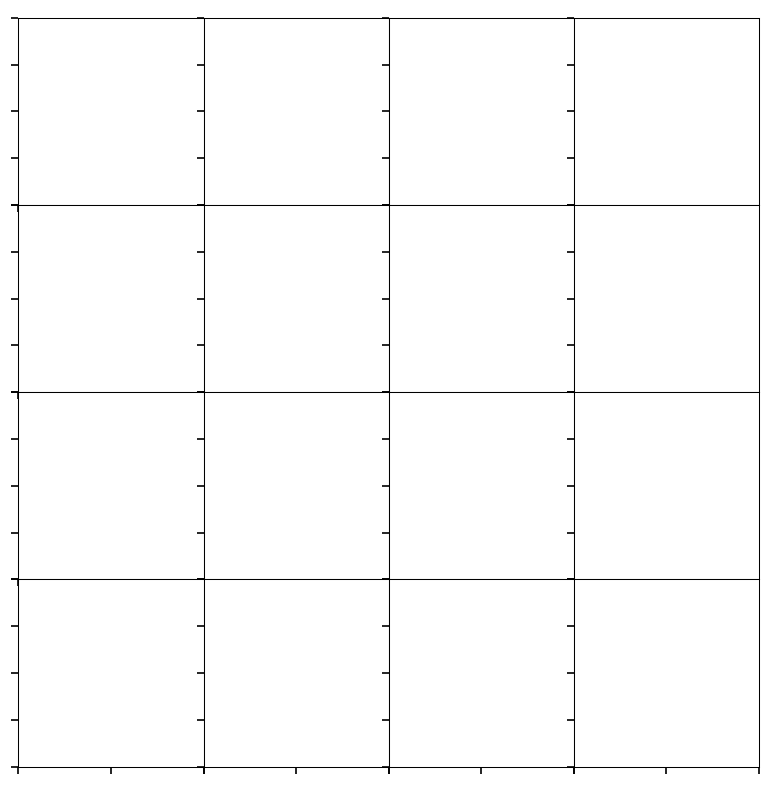

In [4]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
fig, axarr = plt.subplots(4,4, figsize=(6.37, 6.61), dpi=150)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i in range(4):
    for j in range(4):
        axarr[i, j].xaxis.set_ticklabels([])
        axarr[i, j].yaxis.set_ticklabels([])        